# 前準備

In [1]:
!pip install linearmodels

You should consider upgrading via the '/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/bin/python -m pip install --upgrade pip' command.


In [10]:
import hashlib

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import matplotlib.pyplot as plt


from tqdm import tqdm
from scipy import stats

URL_LENTA_DATA = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/lenta_dataset.csv'
URL_CLUSTER_TRIAL = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_cluster_trial.csv'
URL_STRATIFIED_TRIAL = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_stratified_trial.csv'
URL_AATEST = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_aatest_trial.csv'
URL_NONCOMPLIANCE = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_noncompliance_abtest.csv'

# A/Bテストについての発展的な話題

## A/Aテスト：A/Bテスト設計の妥当性を確認する
### プログラム3.1 割当単位と分析単位が不一致な場合の回帰分析

書籍上では次のようなコードになっています。
```
import pandas as pd
import statsmodels.formula.api as smf

df_cluster_trial= pd.read_csv(URL_CLUSTER_TRIAL)
result = smf.ols(
    "is_click ~ is_treatment", data=df_cluster_trial
).fit()
result.summary()
```

In [36]:
df_cluster_trial= pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


In [37]:
result = smf.ols(
    "is_click ~ is_treatment", data=df_cluster_trial
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5216,0.008,69.521,0.000,0.507,0.536
is_treatment,-0.0232,0.010,-2.365,0.018,-0.043,-0.004


### プログラム3.2 A/A テストの分析（A/A テストが成功しているとき）
書籍上では次のようなコードになっています。
```
import pandas as pd dfdf_aatest = pd.read_csv(URL_AATEST)result = smf.ols("is_click~is_treatment", data=df_aatest).fit()result.summary().tables[1]
```

In [38]:
# 読み込み
df_aatest = pd.read_csv(URL_AATEST)
df_aatest

,uid,is_treatment,is_click
0,0,1,0
1,1,1,0
2,2,1,1
3,3,0,1
4,4,0,1
...,...,...,...
9995,9995,1,1
9996,9996,1,1
9997,9997,0,1
9998,9998,1,0


In [42]:
# A/Aテストの分析
result = smf.ols("is_click~is_treatment", data=df_aatest).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4988,0.007,70.327,0.000,0.485,0.513
is_treatment,0.0102,0.010,1.015,0.310,-0.009,0.030


### プログラム3.3 A/A テストのリプレイ

書籍上では次のようなコードになっています。
```
import hashlibimport pandas as pdimport numpy as npimport statsmodels. formula. api as smffrom tqdm import tqdm

def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2

df_aatest = pd.read_csv(URL_AATEST)
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{i}'
    df_aatest['is_treatment_in_aa'] = df_aatest['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_aatest).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)
```

In [49]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


df_aatest = pd.read_csv(URL_AATEST)
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{i}'
    df_aatest['is_treatment_in_aa'] = df_aatest['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_aatest).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.33it/s]


#### プログラム3.4 A/A テストのリプレイの可視化
本文では次のようになっています。
```
fig, ax = plt. subplots(1, 1, figsize=(5, 4))ax.hist(replays)ax.spines['top'].set_visible(False)ax.spines['right'].set_visible(False)ax.set_facecolor("none")ax.set_xlabel('pvalue')ax.set_title('distribution of pvalue')plt.show()
```

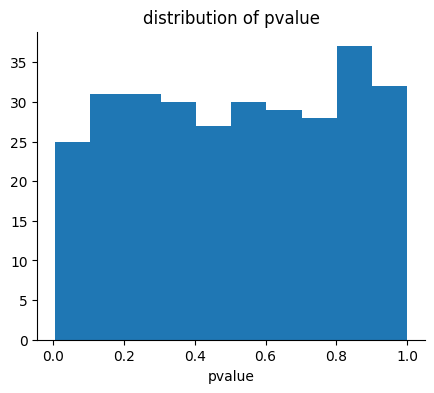

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

#### プログラム3.5 コルモゴロフ─スミルノフ検定による分布の確認
本文では次のようになっています。
```
from scipy import statsstats. kstest(replays, 'uniform', args=(0, 1))
```

In [52]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.04504551195892681, pvalue=0.5611215508935568, statistic_location=0.6883788452922601, statistic_sign=-1)

## 状況に応じたA/Bテストのモデリング

### クラスターA/BテストCluster A/B Test 

#### プログラム3.6 クラスターA/B テストデータにおけるA/A テストのリプレイ
本文では次のようになっています。
```
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2

rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{i}'
    df_cluster['is_treatment_in_aa'] = \
        df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)
```

In [59]:
df_cluster = pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


In [57]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2

rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{i}'
    df_cluster['is_treatment_in_aa'] = \
        df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.55it/s]


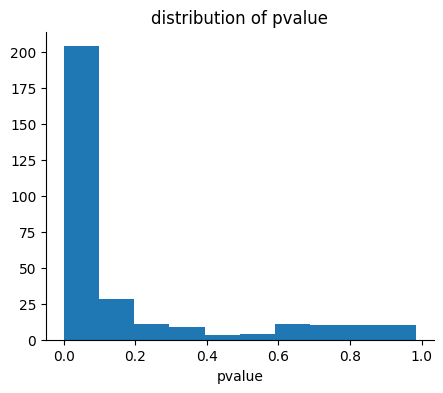

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
[spin.set_visible(False) for spin in list(ax.spines.values())]
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [58]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.6134127868406709, pvalue=4.70019809957193e-109, statistic_location=0.056587213159329075, statistic_sign=1)

#### プログラム3.7 クラスターA/B テストデータの分析
本書では次のようなコードになっています
```
import pandas as pdimport statsmodels. formula. api as smf

# データの読み込み
df_cluster_trial= pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster_trial
# 分散を補正して推定
result = smf.ols("is_click ~ is_treatment", data=df_cluster).fit()
result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
result_correted.summary().tables[1]
```

- データの読み込み

In [63]:
# データの読み込み
df_cluster_trial= pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


- 分散を補正する

In [62]:
# 分散を補正して推定
result = smf.ols("is_click ~ is_treatment", data=df_cluster).fit()
result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
result_correted.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5216,0.033,15.632,0.000,0.456,0.587
is_treatment,-0.0232,0.043,-0.539,0.590,-0.108,0.062


#### プログラム3.8 クラスターA/BテストデータのA/Aテスト

```
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2

rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{i}'
    df_cluster['is_treatment_in_aa'] = df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
    pvalue = result_correted.pvalues[result_correted.model.exog_names.index('is_treatment_in_aa')]
    # 情報の格納
    replays.append(pvalue)
```

In [64]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2

rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{i}'
    df_cluster['is_treatment_in_aa'] = df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
    pvalue = result_correted.pvalues[result_correted.model.exog_names.index('is_treatment_in_aa')]
    # 情報の格納
    replays.append(pvalue)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.38it/s]


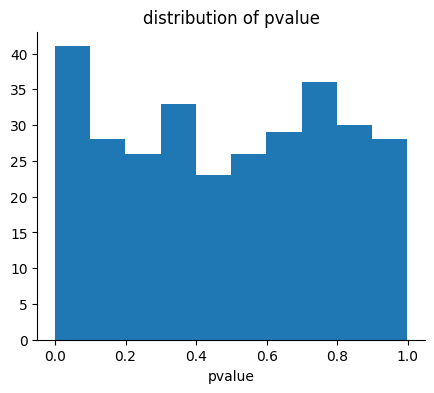

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
[spin.set_visible(False) for spin in list(ax.spines.values())]
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [67]:
# 本文には掲載していない
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.04319182166835675, pvalue=0.6145727388836066, statistic_location=0.08347484499830993, statistic_sign=1)

### 層化A/Bテスト Stratified A/B Test

#### プログラム3.9 シミュレーション：ランダムな割り当てをした場合の性別割合の偏り
本文では次のように掲載しています。
```
rng = np.random.default_rng(seed=0)
ratio = [rng.choice([0, 1], p = [0.5, 0.5], size = 500).mean() for _ in range(100)]
plt.hist(ratio)
plt.xlabel('ratio of man')
plt.ylabel('probablity')
plt.show()
```

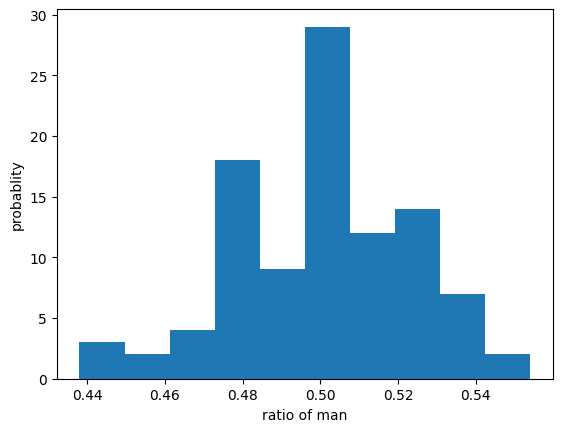

In [79]:
rng = np.random.default_rng(seed=0)
ratio = [rng.choice([0, 1], p = [0.5, 0.5], size = 500).mean() for _ in range(100)]
plt.hist(ratio)
plt.xlabel('ratio of man')
plt.ylabel('probablity')
plt.show()

#### プログラム3.10 層化A/B テストにおけるランダムな割り当て
本文では次のように掲載しています。

```
import pandas as pdimport seaborn as snsimport numpy as np

def stratified_assiginment(df_group, ratio_treat, rng, column_name):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(df_group.index, num_samples, replace=False)
    df_group.loc[treat_indices, column_name] = 1
    return df_group

df_titanic = sns.load_dataset('titanic')[['survived', 'sex', 'pclass']]
rng = np.random.default_rng(11)
df_titanic_assigned = (
    df_titanic
    .groupby(['sex', 'pclass'], group_keys=False)
    .apply(
        stratified_assiginment, 
        ratio_treat = 0.3, column_name = 'is_treat', rng = rng
    )
)
```

In [80]:
df_titanic = sns.load_dataset('titanic')[['survived', 'sex', 'pclass']]
df_titanic

,survived,sex,pclass
0,0,male,3
1,1,female,1
2,1,female,3
3,1,female,1
4,0,male,3
...,...,...,...
886,0,male,2
887,1,female,1
888,0,female,3
889,1,male,1


In [81]:
# グループごとに無作為抽出による割当を行う関数
def stratified_assiginment(df_group: pd.DataFrame, ratio_treat: float, rng: np.random.Generator, column_name = 'is_treat',):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(df_group.index, num_samples, replace=False)
    df_group.loc[treat_indices, column_name] = 1
    return df_group

# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = (
    df_titanic
    .groupby(['sex', 'pclass'], group_keys=False)
    .apply(
        stratified_assiginment, 
        ratio_treat = 0.3, column_name = 'is_treat', rng = rng
    )
)

In [82]:
df_titanic_assigned

,survived,sex,pclass,is_treat
0,0,male,3,0
1,1,female,1,0
2,1,female,3,1
3,1,female,1,0
4,0,male,3,0
...,...,...,...,...
886,0,male,2,1
887,1,female,1,0
888,0,female,3,0
889,1,male,1,0


In [83]:
df_titanic_assigned.groupby(['sex', 'pclass'])['is_treat'].mean()

sex     pclass
female  1         0.297872
        2         0.302632
        3         0.298611
male    1         0.303279
        2         0.296296
        3         0.299712
Name: is_treat, dtype: float64

#### 層化A/Bテストの分析の実装

- データの読み込み

In [85]:
df_stratified = pd.read_csv(URL_STRATIFIED_TRIAL)
df_stratified

,is_treatment,group_name,y
0,0,0,-7.094851
1,0,0,-2.853676
2,1,0,-3.024156
3,1,0,-4.989469
4,1,0,-2.724840
...,...,...,...
104,0,1,-9.971287
105,1,1,-10.593688
106,1,1,-6.990840
107,0,1,-7.833720


- グループごとの平均的なアウトカム

In [86]:
df_stratified.groupby(['group_name', 'is_treatment']).mean()

y
group_name is_treatment           
0          0             -4.712623
           1             -4.231232
1          0            -10.039635
           1             -9.354120

#### プログラム3.11 層化A/B テストの分析（通常のA/B テストと同様に行った場合）
本書では次のように掲載しています。
```
import pandas as pdimport statsmodels. formula. api as smf

df_stratified = pd.read_csv(URL_STRATIFIED_TRIAL)
result = smf.ols("y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]
```

In [87]:
result = smf.ols("y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.9951,0.332,-18.036,0.000,-6.654,-5.336
is_treatment,0.5530,0.468,1.182,0.240,-0.375,1.481


#### プログラム3.11 層化A/B テストの分析
```
result = smf.ols("y ~ is_treatment + C(group_name)", data=df_stratified).fit()
result.summary().tables[1]
```

In [88]:
result = smf.ols("y ~ is_treatment + C(group_name)", data=df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.7373,0.141,-33.649,0.000,-5.016,-4.458
C(group_name)[T.1],-5.2247,0.216,-24.182,0.000,-5.653,-4.796
is_treatment,0.5301,0.184,2.878,0.005,0.165,0.895


## 処置と割当の不一致 A/B テストにおける Non-compliance
#### プログラム3.12 Intent to Treat の分析
本文では次のように掲載しています。
```
import pandas as pdimport statsmodels. formula. api as smf

# データの読み込みdf_noncompliance= pd.read_csv(URL_NONCOMPLIANCE)df_noncompliance# Intent to Treatの分析result = smf.ols("purchase ~ assignment", data=df_noncompliance).fit()result.summary().tables[1]
```

- データのimport

In [129]:
# データの読み込み
df_noncompliance= pd.read_csv(URL_NONCOMPLIANCE)
df_noncompliance

,assignment,x,is_deliver,purchase
0,0.0,0.017286,0.0,10563.182011
1,1.0,-0.037921,1.0,8861.781424
2,1.0,0.056103,0.0,11450.231477
3,1.0,-0.213583,0.0,8357.833101
4,0.0,0.023237,0.0,10755.016507
...,...,...,...,...
995,0.0,-0.082353,0.0,9127.673875
996,0.0,-0.108672,0.0,9919.530298
997,1.0,-0.125113,0.0,9469.139734
998,1.0,0.140215,1.0,11103.908090


In [130]:
# Intent to Treatの分析
result = smf.ols("purchase ~ assignment", data=df_noncompliance).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9918.2820,64.690,153.321,0.000,9791.338,1e+04
assignment,197.0536,92.320,2.134,0.033,15.890,378.217


トリートメント群およびコントロール群の平均的な開封割合

In [131]:
df_noncompliance.groupby('assignment')['is_deliver'].mean()

assignment
0.0    0.000000
1.0    0.450102
Name: is_deliver, dtype: float64

####  プログラム3.13 操作変数法の2段階推定による施策効果を復元する分析
本文では次のように掲載しています。

```
from linearmodels.iv import IV2SLS
# 操作変数法の2段階推定iv = IV2SLS.from_formula("purchase ~ 1 + [is_deliver ~ assignment] + x", df_noncompliance).fit()iv.summary.tables[1]
```

In [132]:
iv = IV2SLS.from_formula("purchase ~ 1 + [is_deliver ~ assignment] + x", df_noncompliance).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9943.6,42.853,232.04,0.0000,9859.6,1.003e+04
x,9714.6,290.72,33.416,0.0000,9144.8,1.028e+04
is_deliver,533.98,141.26,3.7802,0.0002,257.12,810.84


first stage確認

In [133]:
iv.first_stage

,is_deliver
R-squared,0.3018
Partial R-squared,0.2977
Shea's R-squared,0.2977
Partial F-statistic,408.62
P-value (Partial F-stat),0.0000
Partial F-stat Distn,chi2(1)
==========================,==========
Intercept,0.0009
,(0.5299)
x,0.3463


# 共変量を入れて分析をする
#### プログラム3.14 共変量を考慮したA/B テストの分析
本文では次のように記していました。
```
df_abterst = pd.read_csv(URL_LENTA_DATA)result_with_covariates = smf.ols(
    "response_att ~ is_treatment + food_share_15d + age + is_women",
    data=df_abtest
).fit()result_with_covariates.summary().tables[1]
```

In [96]:
# サブサンプル分割
df_abtest = pd.read_csv(URL_LENTA_DATA)
df_abtest

,is_treatment,response_att,food_share_15d,age,is_women
0,1,0,0.0000,33.0,1
1,0,0,0.0000,63.0,1
2,1,0,0.0000,51.0,1
3,0,0,0.0000,38.0,1
4,1,0,0.5105,20.0,1
...,...,...,...,...,...
49995,1,0,0.0000,60.0,1
49996,0,0,0.0000,26.0,0
49997,1,0,0.8461,28.0,1
49998,1,0,0.0000,19.0,1


In [99]:
df_abterst = pd.read_csv(URL_LENTA_DATA)
result_with_covariates = smf.ols(
    "response_att ~ is_treatment + food_share_15d + age + is_women",
    data=df_abtest
).fit()
result_with_covariates.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0539,0.005,10.555,0.000,0.044,0.064
is_treatment,0.0072,0.003,2.285,0.022,0.001,0.013
food_share_15d,0.1713,0.003,51.131,0.000,0.165,0.178
age,-0.0003,9.3e-05,-3.047,0.002,-0.000,-0.000
is_women,0.0033,0.003,1.157,0.247,-0.002,0.009


- A/Bテストの結果再掲

In [98]:
result_plain = smf.ols("response_att ~ is_treatment ", data=df_abtest).fit()
result_plain.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1024,0.003,36.412,0.000,0.097,0.108
is_treatment,0.0091,0.003,2.809,0.005,0.003,0.015


# 施策効果の異質性 ~ どこで効果があるのか知る

#### プログラム3.15 サブサンプル分割による異質性の分析

```
import pandas as pdimport statsmodels. formula. api as smffrom statsmodels. iolib. summary2 import summary_col

# サブサンプル分割
df_men = df_abtest.loc[df_abtest['is_women'] == 0, :]
df_women = df_abtest.loc[df_abtest['is_women'] == 1, :]
# 推定（is_women = 0）
result_men = smf.ols("response_att ~ is_treatment", data=df_men).fit()
result_men.summary().tables[1]
# 推定（is_women = 1）
result_women = smf.ols("response_att ~ is_treatment", data=df_women).fit()
result_women.summary().tables[1]
# 推定した結果をまとめて表示
summary_col(
    [result_men, result_women],
    model_names=('only men model', 'only women model'), stars=True
)
```

In [100]:
# サブサンプル分割
df_men = df_abtest.loc[df_abtest['is_women'] == 0, :]
df_women = df_abtest.loc[df_abtest['is_women'] == 1, :]

In [101]:
# 推定（is_women = 0）
result_men = smf.ols("response_att ~ is_treatment", data=df_men).fit()
result_men.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.021,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.543,0.011,0.003,0.024


In [23]:
# 推定（is_women = 1）
result_women = smf.ols("response_att ~ is_treatment", data=df_women).fit()
result_women.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1032,0.004,29.006,0.000,0.096,0.110
is_treatment,0.0065,0.004,1.583,0.113,-0.002,0.014


In [102]:
# 推定した結果をまとめて表示
summary_col(
    [result_men, result_women],
    model_names=('only men model', 'only women model'), stars=True
)

,only men model,only women model
Intercept,0.1010***,0.1032***
,(0.0046),(0.0036)
is_treatment,0.0135**,0.0065
,(0.0053),(0.0041)
R-squared,0.0003,0.0001
R-squared Adj.,0.0003,0.0000


In [25]:
# ダミー変数であるis_womenカラムの中身を確認する
df_abtest[['is_women']]

,is_women
0,1
1,1
2,1
3,1
4,1
...,...
49995,1
49996,0
49997,1
49998,1


#### プログラム3.16 交差項による異質性の分析
本文では次のように記載しています。
```
import pandas as pd
import statsmodels.formula.api as smf

# 推定
result_hetero = smf.ols(
    "response_att ~ is_treatment + is_women + is_treatment * is_women",
    data=df_abtest
).fit()
# 推定結果の表示
result_hetero.summary().tables[1]
```

In [103]:
# 推定
result_hetero = smf.ols(
    "response_att ~ is_treatment + is_women + is_treatment * is_women",
    data=df_abtest
).fit()
# 推定結果の表示
result_hetero.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.184,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.562,0.010,0.003,0.024
is_women,0.0022,0.006,0.380,0.704,-0.009,0.014
is_treatment:is_women,-0.0070,0.007,-1.050,0.294,-0.020,0.006
